In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')

import random
import numpy as np
import pandas as pd
from spykes.neurovis import NeuroVis
from spykes.popvis import PopVis

### 0.1 Download data

#### Download all files [[here](https://figshare.com/articles/Ramkumar_et_al_2016_Premotor_and_motor_cortices_encode_reward/3573447)]. We'll only be looking at Mihili_08062013.mat (Monkey M, Session 4)  

### 0.2 Read In Data

In [2]:
import scipy.io
mat = scipy.io.loadmat('3573447/Mihili_08062013.mat')

### 0.3 Initialize Variables


In [3]:
event = 'rewardTime'
condition = 'rewardBool'
window = [-500, 1500]
binsize = 10

### 1.1. Initiate all Neurons

In [4]:
def get_spike_time(raw_data, neuron_number):
    
    spike_times = raw_data['alldays'][0]['PMd_units'][0][:][neuron_number-1][0][1:]
    spike_times = [i[0] for i in spike_times]
    
    return spike_times

In [5]:
def initiate_neurons(raw_data):
    
    neuron_list = list()
    
    for i in range((raw_data['alldays'][0]['PMd_units'][0][:]).shape[0]):
        spike_times = get_spike_time(raw_data, i+1)

        # instantiate neuron
        neuron = NeuroVis(spike_times, name = 'PMd %d' % (i+1))
        neuron_list.append(neuron)
        
    return neuron_list

In [6]:
neuron_list = initiate_neurons(mat)

### 1.2. Get event times

In [7]:
def create_data_frame(raw_data):

    data_df = pd.DataFrame()
    
    uncertainty_conditions = list()
    center_target_times = list()
    reward_times = list()
    reward_outcomes = list()
    
    for i in range(raw_data['alldays'].shape[0]):
            
        meta_data = raw_data['alldays'][i]['tt'][0]
        
        uncertainty_conditions.append(meta_data[:,2])
        center_target_times.append(meta_data[:,3])
        reward_times.append(meta_data[:,6])
        reward_outcomes.append(meta_data[:,7])
        
    data_df['uncertaintyCondition'] = np.concatenate(uncertainty_conditions)
    data_df['centerTargetTime'] = np.concatenate(center_target_times)
    data_df['rewardTime'] = np.concatenate(reward_times)
    data_df['rewardOutcome'] = np.concatenate(reward_outcomes)
        
    data_df['rewardBool'] = data_df['rewardOutcome'].map(lambda s: s == 32)
    
    # find time in between previous reward onset and start of current trial
    # shouldn't be more than 1500ms
    
    start_times = data_df['centerTargetTime']
    last_reward_times = np.roll(data_df['rewardTime'], 1)
    
    diffs = start_times - last_reward_times
    diffs[0] = 0
    
    data_df['consecutiveBool'] = diffs.map(lambda s: s <= 1.5)
        
    return data_df[((data_df['uncertaintyCondition'] == 5.0) | (data_df['uncertaintyCondition'] == 50.0)) 
                  & data_df['consecutiveBool']]  

In [8]:
data_df = create_data_frame(mat)
print len(data_df)
data_df.head()

691


,uncertaintyCondition,centerTargetTime,rewardTime,rewardOutcome,rewardBool,consecutiveBool
280,5.0,1481.082633,1483.947,34.0,False,True
284,5.0,1509.540300,1511.946,34.0,False,True
285,5.0,1513.181333,1515.847,32.0,True,True
286,5.0,1516.982767,1519.256,32.0,True,True
287,50.0,1520.391233,1523.123,32.0,True,True


### 1.3. Create PopVis Object

In [9]:
neuron_list = initiate_neurons(mat)[:10] # let's just look at first 10 neurons
pop = PopVis(neuron_list)

#### 1.3.1 Plot Heat Map

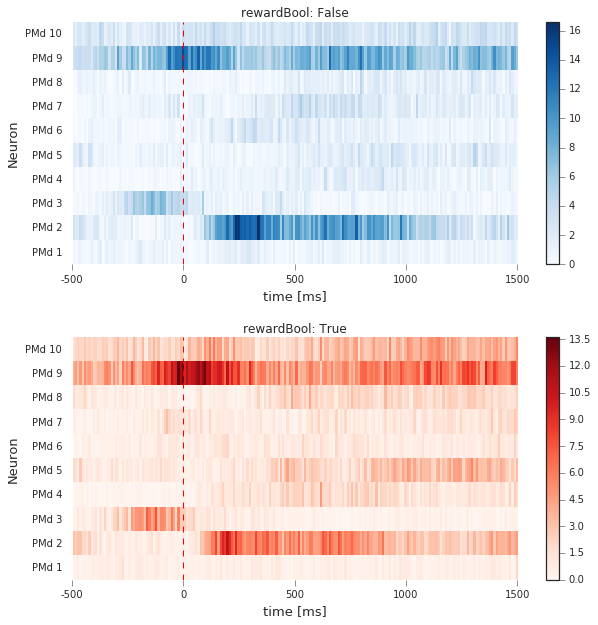

In [10]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=.3)
all_psth = pop.get_all_psth(event=event, df=data_df, conditions=condition, window=window, binsize=binsize, plot=True)

#### 1.3.2 Plot Heat Map. Sort by Peak Latency

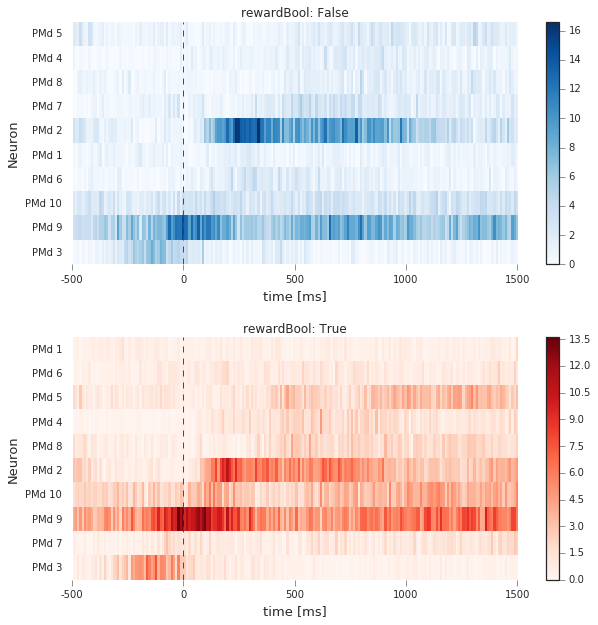

In [11]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=.3)
pop.plot_heat_map(all_psth, sortby='latency')

#### 1.3.3 Plot Heat Map. Sort by Avg Firing Rate in Ascending Order

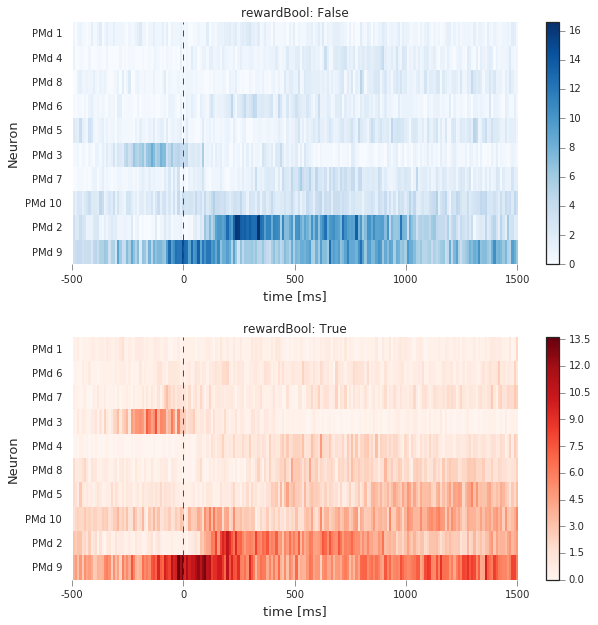

In [12]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=.3)
pop.plot_heat_map(all_psth, sortby='rate', sortorder='ascend')

#### 1.3.4 Plot Heat Map. Normalize Each Neuron Individually.

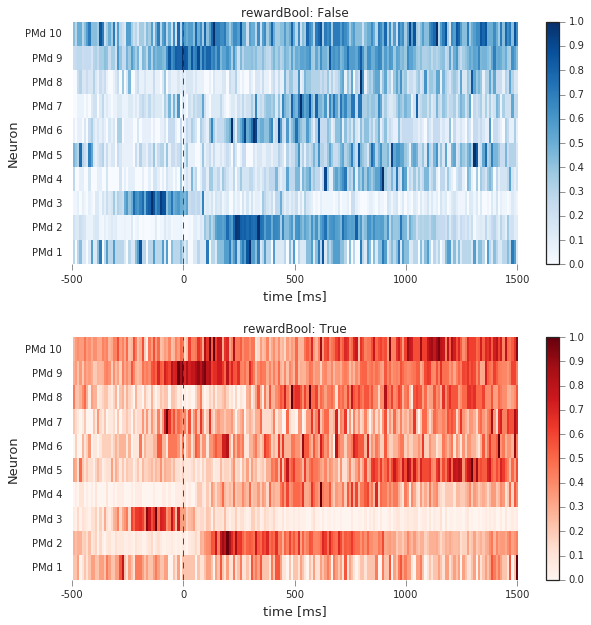

In [13]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=.3)
pop.plot_heat_map(all_psth, normalize='each')

#### 1.3.5 Plot Heat Map. Normalize All Neurons Together and Sort in Specified Order.

[5, 6, 0, 9, 8, 1, 2, 4, 3, 7]


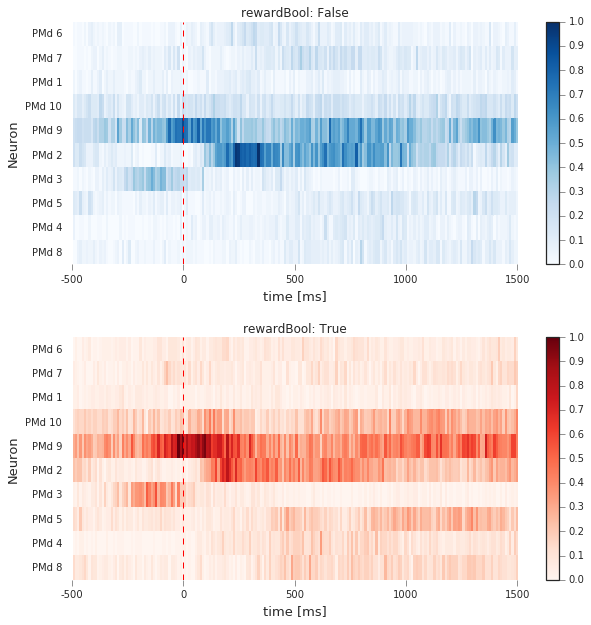

In [14]:
random_list = range(10)
random.shuffle(random_list)
print random_list
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=.3)
pop.plot_heat_map(all_psth, normalize='all', sortby=random_list)

#### 1.3.6 Plot Population PSTH

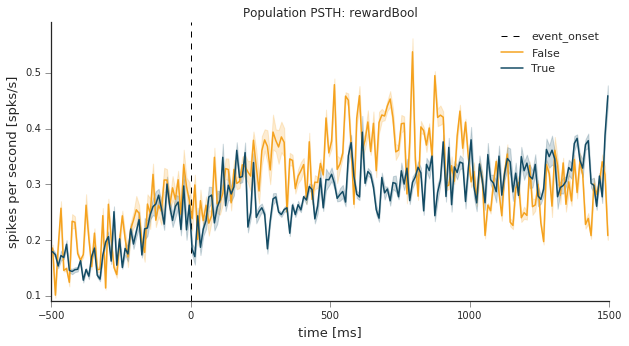

In [16]:
plt.figure(figsize=(10,5))
pop.plot_population_psth(all_psth=all_psth)